# Group Members
- Pflum, Jordan
- Cheng, Tim
- Girtharan, Mervyn

# Logistics
You must create one Jupyter notebook for the entire assignment, and upload
it to Canvas by **August 6, before class begins.**

# Introduction
Suppose we have a bunch of URLs and we want to know their adult-rating
(i.e., is the url P, or G, or X, or R). This task is dificult for computers,
but easy for humans, and this has led to the growth of crowdsourcing: get
a bunch of humans to give ratings to urls, but use automated techniques to
figure out how much to trust each person's ratings.
 
We are going to use the data from a paper by Ipeirotis et al. available
here. This details an experiment run on Amazon's Mechanical Turk crowd-
sourcing system. They ask a bunch of raters (called "turks") to rate several
urls, but they already know the answers (the true categories) for a few urls,
called the "gold set". The ratings of the turks on the gold set thus allows us
to judge their accuracy.

# Q1 (10pts) Read in data
Read in the files gold.txt and labels.txt. The gold DataFrame should
have columns url and category, while the labels DataFrame should have
columns turk, url and category. You will have to pick the right separator.

In [2]:
import pandas as pd

# Read in Gold Set and Labels Set
goldData = pd.read_csv('gold.txt', names=['url','category'],delimiter='\t')
labelsData = pd.read_csv('labels.txt', names=['turk', 'url', 'category'],delimiter='\t')

# Q2 (10pts) Split into two DataFrames
Split the labels DataFrame into two: labels_on_gold and labels_unknown,
the former containing all rows where the url is present in the gold set, and
the latter one contains all remaining rows of labels.

In [3]:
# Create Dataframe of Lables in Gold Set
labels_on_gold = pd.merge(goldData, labelsData, how='inner', on=['url'])
labels_on_gold = labels_on_gold.reset_index()[['turk', 'url', 'category_x', 'category_y']]
labels_on_gold = labels_on_gold.rename(columns={'turk': 'turk', 
                                                'url': 'url', 
                                                'category_x': 'category_gold', 
                                                'category_y': 'category_turk'})

# Create Dataframe of Lables not in Gold Set
labels_unknown = pd.merge(labelsData, goldData, on=['url'],how="outer",indicator=True)
labels_unknown = labels_unknown[labels_unknown['_merge']=='left_only']
labels_unknown = labels_unknown.reset_index()[['turk', 'url', 'category_x']]
labels_unknown = labels_unknown.rename(columns={'turk': 'turk', 'url': 'url', 'category_x': 'category'})

print(labels_on_gold.head())
print(labels_unknown.head())

             turk                        url category_gold category_turk
0  A1253FXHCZ9CWM  http://0800-horoscope.com             G             G
1  A153PKAL7OAY36  http://0800-horoscope.com             G             G
2  A1FV9SAPL5C6KY  http://0800-horoscope.com             G             G
3  A1JTOT0DWM6QGL  http://0800-horoscope.com             G             G
4  A1PXXEOGQ76RNJ  http://0800-horoscope.com             G             G
             turk            url category
0  A1OT3A29R9N1DG  http://000.cc        P
1  A1PXXEOGQ76RNJ  http://000.cc        G
2  A1PXXEOGQ76RNJ  http://000.cc        G
3  A21US576U8SCO4  http://000.cc        G
4  A2LGX47NN7C5D3  http://000.cc        G


# Q3 (10pts) Compute Accuracies of turks
Create a rater_goodness DataFrame that is indexed by turk, and has two
columns: the number of ratings, and the average correctness of ratings for
each turk (both on gold set urls).

In [19]:
# Get Total number ratings per turk
labels_on_gold_turk_total = labels_on_gold['turk'].value_counts()
labels_on_gold_turk_total = labels_on_gold_turk_total.rename("numRatings")

#print(labels_on_gold_turk_total)
#print(labels_on_gold)

print("A32309NYZO1QFB" == labels_on_gold_turk_total.index)

# Get total ratings correct per turk
labels_on_gold_correct = labels_on_gold[labels_on_gold['category_gold'] == labels_on_gold['category_turk']]
labels_on_gold_correct_count = labels_on_gold_correct['turk'].value_counts()

# Get total correct ratings percent (adjusting null values to 0 - turk did not rate any gold set correctly)
labels_on_gold_correct_percent = labels_on_gold_correct_count / labels_on_gold_turk_total
labels_on_gold_correct_percent[labels_on_gold_correct_percent.isnull()] = 0
labels_on_gold_correct_percent = labels_on_gold_correct_percent.rename("avgCorrectness")

# Merge Dataframes
rater_goodness = pd.concat([labels_on_gold_turk_total, labels_on_gold_correct_percent], axis=1)


print(rater_goodness)
#print(len(rater_goodness))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

# Q4 Odds Ratios
If someone is correct $p$ fraction of the time, the *odds* of success are defined as: $$\mbox{odds } = \frac{p}{1.001 - p}$$ Attach a column called *odds* to the *rater_goodness* DataFrame, using the average correctness of the turk as his or her *p*.

In [4]:
def calculateOdds(p):
    """Calculate odds ratio"""
    """odds= p / 1.001-p   """
    
    odds = p / (1.001 - p)
    
    return odds

# Create odds column for rater_goodness dataframe
rater_goodness['odds'] = rater_goodness['avgCorrectness'].map(calculateOdds)



print(rater_goodness.head())
print(len(rater_goodness))

                numRatings  avgCorrectness      odds
A31OCN4MNHUQ6W         184        0.777174  3.472222
A153PKAL7OAY36         148        0.722973  2.600369
A2BTR0GQ5B5JI6         126        0.523810  1.097695
ATVALOQVDCMZW          103        0.854369  5.826657
AZSDW7JJL5VA7          100        0.680000  2.118380
269


# Q5 (10pts) Most Accurate Turks
List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [76]:
rater_goodness_top10 = rater_goodness[rater_goodness['numRatings'] >= 20].sort_values('avgCorrectness', ascending=False)
rater_goodness_top10[:10]


print(rater_goodness_top10[:20])
print(len(rater_goodness_top10))

                numRatings  avgCorrectness
A2U0R4X38GUKZE          20        0.950000
A22C0PJUBFJTI0          36        0.916667
A23YQUBXZPKILZ          24        0.875000
ATVALOQVDCMZW          103        0.854369
A1HIXWH4OXT8S4          40        0.825000
A3220HG1O83HQ4          22        0.818182
A32W20KGQXS0LL          25        0.800000
A20PWAB7G3HDHU          20        0.800000
AJSJVK40F5HM6           28        0.785714
A31OCN4MNHUQ6W         184        0.777174
A3MA9V9UPGCOK7          71        0.774648
A3IP9KYNZZ028B          22        0.772727
A3477QYMFXUC4I          25        0.760000
A1JTOT0DWM6QGL          29        0.758621
A25CRC4AZY5KC1          48        0.750000
A12RE8G66WTO8B          20        0.750000
A35GER5TWMH9VP          64        0.750000
AVWJPWUEE3U4Q           36        0.750000
APYV9Y0DFZFVP           71        0.746479
A153PKAL7OAY36         148        0.722973
52


# Q6 (10pts) Rating Counts versus accuracy
One may imagine that a committed and accurate turk will rate lots of URLs.
On the other hand, perhaps it is only the spammers who have the time to
rate lots of URLs.

Is number of ratings by a turker on gold set URLs related to his or her
accuracy? There's no fixed answer; just try to show some evidence for your
answer.

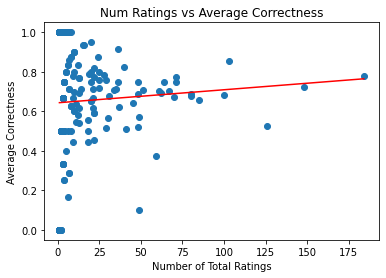

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Wed, 05 Aug 2020   Prob (F-statistic):              0.459
Time:                        18:37:25   Log-Likelihood:                -94.663
No. Observations:                 269   AIC:                             193.3
Df Residuals:                     267   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6431      0.024     27.071      0.0

In [6]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set X and Y
Y = rater_goodness['avgCorrectness'].values.reshape(-1,1)
X = rater_goodness['numRatings'].values.reshape(-1,1)

# Add Constant
X = sm.add_constant(X)

# Linear Model and Prediciton
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

# Rest x,y for plotting
y = rater_goodness['avgCorrectness'].values
x = rater_goodness['numRatings'].values

# Plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x, predictions, c='r')
ax1.scatter(x, y)
plt.title('Num Ratings vs Average Correctness')
plt.xlabel('Number of Total Ratings')
plt.ylabel('Average Correctness')
plt.show()

# Linear Model Summary
print(model.summary())

print(rater_goodness['avgCorrectness'].corr(rater_goodness['numRatings']))

I would argue that the number of ratings by a turk on Gold Set URLs is not related to thier accuracy. When running a simple linear regression using number of total ratings to predict average ratings, we find that the total number of ratings has a positive relationship with average correctness. The regression shows us that on average, ignoring all other factors, we would expect to see a .07% increase in average correctness for every number of total ratings.  However, the number of total ratings predictor is not statistically signficant with a T-Stat of 0.741. Therefore, although there appears to be a relationship between rating and number of ratings, because the statistic is not statistically significant we fail to reject the null hypothesis that the predictor has any impact on average rating. Additionally, when computing the correlation between averageAccuracy and numRatings we find that the two statistics have a very low correlation value (0.0453).

# Q7 (pts 13) Overall predicted odds
Consider each url *u* that is not in the gold set, and each category *c*. For the
pair (*u*, *c*), calculate the product of odds of all turks who (a) rated url *u* as
category *c*, and (b) have rated more gold set urls than 75% of all turks who
rated at least one gold-set url.

For example, if you find that there are 269 turks who rated at least one
gold-set url, you want to select only the turks who have rated more gold-set
urls than 75% of these 269 turks. We can think of these as our "reliable"
turks. Now, our belief that url *u* belongs to category *c* depends on how many
"reliable" turks rated *u* as *c*; specifically, our belief is based on the product
of their reliability scores (i.e., their odds).

We shall call such products of odds the *overall odds* henceforth.

In [39]:
import math

# Calculate num of turks in 25 percentile
total = len(rater_goodness)
_25perc = math.floor(total*.25)

# Get top 25% turks by number of ratings (at least one in gold set)
rater_goodness = rater_goodness.sort_values('numRatings', ascending=False)
rater_goodness_top25perc = rater_goodness[:_25perc]
rater_goodness_top25perc = rater_goodness_top25perc.reset_index()
rater_goodness_top25perc = rater_goodness_top25perc.rename(columns={'index': 'turk', 
                                                                    'numRatings': 'numRatings', 
                                                                    'avgCorrectness': 'avgCorrectness', 
                                                                    'odds': 'odds'
                                                                   }
                                                          )
# Top 25% turks by number of ratings and their respective ratings in non-goldset
labels_unkown_reliableTurks = pd.merge(rater_goodness_top25perc, labels_unknown , how='inner', on='turk')

# Calculate odds for each category for each url (prod(turk odds for category))
groupedDF = labels_unkown_reliableTurks.groupby(['url', 'category'])[['odds']].prod()

print(groupedDF.head())
print(len(groupedDF))

41633
                                           odds
url                         category           
http://0-101.net            G          2.155963
http://000.cc               G          1.460583
http://0000.jp              G         14.488244
http://000relationships.com G          9.914590
                            P          1.851852
14110


# Q8 (14pts) Predicted Categories
Create a DataFrame (called result_75, whose index is URLs not in the gold
set, and with two columns called top_category and top_odds. The top_category 
should be the category with the highest overall odds for that url,
and the top_odds should be the overall odds for that top_category.

These are our predictions, and the confidence we have in them (higher
overall odds implies greater confidence). If you want, you can check to see if
the predicted categories make sense.

In [44]:
'''
# Correct but inefficient

urls_topCategory = {}
urls_topOdds = {}
for url in groupedDF.index.get_level_values(0):
    urls_topCategory[url] = groupedDF.loc[url,'odds'].idxmax()
    urls_topOdds[url] = groupedDF.loc[url,'odds'].max()

urls_topCategory = pd.Series(urls_topCategory)
urls_topOdds = pd.Series(urls_topOdds)

result_75 = pd.concat([urls_topCategory, urls_topOdds], axis=1)
result_75 = result_75.rename(columns={0: 'top_Category', 
                                      1: 'top_Odds'
                                     }
                            )
'''


result_75 = groupedDF.reset_index().sort_values('odds', ascending=False).drop_duplicates(subset='url').sort_values('url')
result_75 = result_75.set_index('url')
result_75 = result_75.rename(columns={'category': 'top_Category', 
                                      'odds': 'top_Odds'
                                     }
                            )

result_75.head()

# Testing
print(result_75.head())
print(len(result_75))

10702
                            top_Category      top_Odds
url                                                   
http://0-101.net                       G  2.155963e+00
http://000.cc                          G  2.181050e+03
http://0000.jp                         G  2.877556e+07
http://000relationships.com            P  1.851852e+00
http://000vitamins.com                 G  5.014149e+00
10702


# Q9 (14pts) Predicted categories using more turks
Questions 7 and 8 above only considered the ratings of turks who had rated
enough gold set URLs, so we were relatively more confident about their
accuracies. What happens if we loosen this restriction?

Repeat the code of Q7 and Q8, but replacing 75% by 25% in the description 
of Q7 (i.e., we also consider turks who have far fewer gold set ratings).
Call this result 25.

Now let's see how these two results compare. Create a DataFrame where
both the index and the columns are the various categories, and the cells
contain the number of urls with these as the top categories according to
result 75 and result 25.

For example, the cell corresponding to the row category=R and the column 
category=G would be the number of URLs that were predicted to be
R by result 75 but predicted to be G by result 25.

Where are the most errors?

In [72]:
import math
import numpy as np

# Get 75% turks
total = len(rater_goodness)
_75perc = math.floor(total*.75)
rater_goodness = rater_goodness.sort_values('numRatings', ascending=False)
rater_goodness_top75perc = rater_goodness[:_75perc]
rater_goodness_top75perc = rater_goodness_top75perc.reset_index()
rater_goodness_top75perc = rater_goodness_top75perc.rename(columns={'index': 'turk', 
                                                                    'numRatings': 'numRatings', 
                                                                    'avgCorrectness': 'avgCorrectness', 
                                                                    'odds': 'odds'
                                                                   }
                                                          )

# Merge top 75% turks with unknown urls dataset
labels_unkown_unreliableTurks = pd.merge(rater_goodness_top75perc, labels_unknown, how='inner', on=['turk'])

# Get odds
groupedDF = labels_unkown_unreliableTurks.groupby(['url', 'category'])[['odds']].prod()
result_25 = groupedDF.reset_index().sort_values('odds', ascending=False).drop_duplicates(subset='url').sort_values('url')
result_25 = result_25.set_index('url')
result_25 = result_25.rename(columns={'category': 'top_Category', 
                                      'odds': 'top_Odds'
                                     }
                            )



# Put results_25 top_Category counts into series called top_Category_25
result_25_category_counts = result_25['top_Category'].value_counts()
result_25_category_counts = result_25_category_counts.rename('top_Category_25')

# Put results_75 top_Category counts into series called top_Category_75
result_75_category_counts = result_75['top_Category'].value_counts()
result_75_category_counts = result_75_category_counts.rename('top_Category_75')

comparisonTable = pd.merge(result_75, result_25, on = "url", how = "inner")
comparisonTable = comparisonTable[['top_Category_x', 'top_Category_y']]
comparisonTable = comparisonTable.rename(columns={'top_Category_x': 'reliableRatings', 
                                                  'top_Category_y': 'unreliableRatings'
                                                 }
                                        )
comparisonTable["counts"] = 1
predictedCategoriesPivotTable = pd.pivot_table(comparisonTable,
                                               index = "reliableRatings",
                                               columns = "unreliableRatings",
                                               values = "counts", 
                                               aggfunc = sum
                                              )

# Testing
print(predictedCategoriesPivotTable)

unreliableRatings     G    P    R    X
reliableRatings                       
G                  8107  269   68   45
P                   243  757   31    6
R                    54   30  334   12
X                    71    9   25  639


The most errors appear to be in the *G* category. Ideally the 'untrusted' (75 perc) turks would predict the same results as the 'trusted' turks. If this were the case, we would expect the diagonal of the matrix/dataframe to contain the most values, as the diagonal cells are the cells where both groups predicted the same rating for urls. However, we see that the rating *G* is overpredicted, with the cells with higher values being located in the row/column associated with the *G* category.